In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector, SelectKBest, chi2

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

from sklearn.metrics import accuracy_score as accuracy
from sklearn.svm import LinearSVC
from scipy import linalg

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='Blues', edgecolor = 'Black', alpha = 0.6)
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [5]:
# 1 point
def scale(X):
    mean = X.mean()
    std = np.std(X)
    return (X - mean) / std

In [6]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [7]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.copy = copy
        self.with_mean = with_mean
        self.with_std = with_std

    def fit(self, X, y=None):
        self.mean = X.mean()
        self.std = np.std(X)
        return self

    def transform(self, X, y=None, copy=True):
        if (self.with_mean and self.with_std):
            return (X - self.mean) / self.std
        if not (self.with_mean and self.with_std):
            return X
        if not self.with_mean:
            return X / self.std
        if not self.with_std:
            return X - self.mean

In [8]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [9]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[-10.61526685,   1.54798763],
       [ 15.47436703,   0.74529941],
       [  5.78983958,  -1.73528389],
       ...,
       [  8.11630368,   6.34118118],
       [  4.03019147,   4.08484064],
       [ -6.31151361,   6.50630237]])

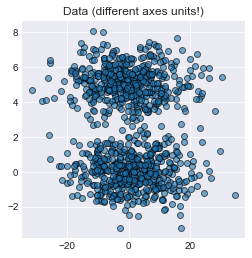

In [10]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

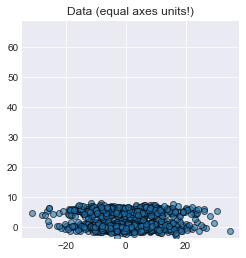

In [11]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

In [12]:
min_max_scaler = MinMaxScaler()
min_max_scaled = min_max_scaler.fit_transform(wine_data)

### StandardScaler (0.5 point)

In [13]:
standard_scaler = StandardScaler()
standard_scaled = standard_scaler.fit_transform(wine_data)

In [14]:
# k - first feature
# l - second feature
# data - list of arrays

def scatter_subplots(data, k = 0, l = 1, titles = []):
    n = len(data)
    fig, axes = plt.subplots(1, n, figsize = (16, 5))
    fig.suptitle(titles[-1], c = 'Midnightblue', size = 14)
    for i in range(n):
        if i == 0:
            data[i] = data[i].to_numpy()
        axes[i].scatter(data[i][:, k], data[i][:, l], cmap = 'Blues', edgecolor = 'Black', alpha = 0.6)
        axes[i].set_title(titles[i])
        axes[i].axis('square')
        axes[i].set_xlabel(wine_data.columns[k])
        axes[i].set_ylabel(wine_data.columns[l])

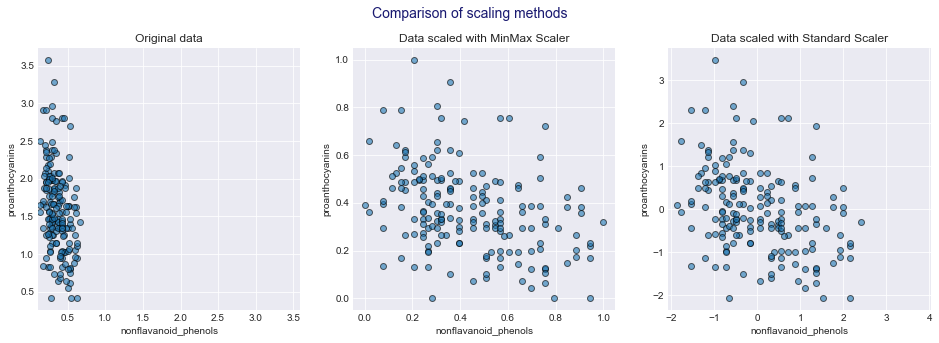

In [15]:
data = [wine_data, min_max_scaled, standard_scaled]
titles = ['Original data', 'Data scaled with MinMax Scaler', 'Data scaled with Standard Scaler', 
          'Comparison of scaling methods']
k = 7
l = k + 1
scatter_subplots(data, k = k, l = l, titles = titles)

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


In [16]:
# import the required library

from sklearn.cluster import KMeans

In [17]:
# Create function for KMeans model

def KMeans_func(data):
    n = len(data)
    centers = []
    labels = []
    for i in range(n):
        kmeans_model = KMeans(n_clusters = 2)
        kmeans_model.fit(data[i])
        centers.append(kmeans_model.cluster_centers_)
        labels.append(kmeans_model.labels_)
    return centers, labels

In [18]:
centers, labels = KMeans_func(data)

In [19]:
# Create function for clusters visualization

def scatter_plot_with_centers(data, centers, labels, k = 0, l = 1, titles = []):
    n = len(data)
    fig, axes = plt.subplots(1, n, figsize = (16, 5))
    fig.suptitle(titles[-1], c = 'Midnightblue', size = 14)
    for i in range(n):
        axes[i].scatter(data[i][:, k], data[i][:, l], c = labels[i], alpha = 0.6, cmap = 'Blues', edgecolor = 'Black')
        axes[i].scatter(centers[i][0, k], centers[i][1, k], c = 'Maroon', marker = 'x', s = 40)
        axes[i].scatter(centers[i][0, l], centers[i][1, l], c = 'Maroon', marker = 'x', s = 40)
        axes[i].set_title(titles[i])  
        axes[i].axis('square')
        axes[i].set_xlabel(wine_data.columns[k])
        axes[i].set_ylabel(wine_data.columns[l])

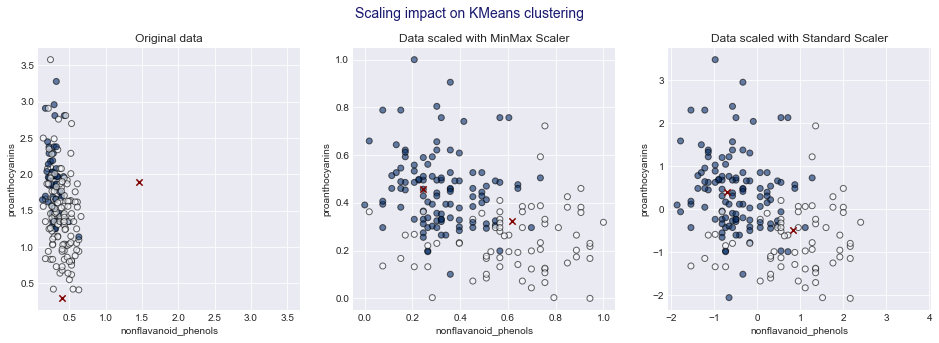

In [20]:
titles = ['Original data', 'Data scaled with MinMax Scaler', 'Data scaled with Standard Scaler', 
          'Scaling impact on KMeans clustering']
scatter_plot_with_centers(data = data, centers = centers, labels = labels, k = k, l = l, titles = titles)

## Exercise  3 - Preprocessing Pipeline (2 points)

In [21]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [22]:
pipeline1 = Pipeline([('classification', LogisticRegression(solver='liblinear', penalty='l1'))])
not_scaled_model = pipeline1.fit(wine_train, wine_labels_train)
not_scaled_accuracy = accuracy(not_scaled_model.predict(wine_val), wine_labels_val)

In [23]:
pipeline2 = Pipeline([('scaling', StandardScaler()), ('classification', LogisticRegression(solver='liblinear', penalty='l1'))])
scaled_model = pipeline2.fit(wine_train, wine_labels_train)
scaled_accuracy = accuracy(scaled_model.predict(wine_val), wine_labels_val)

In [24]:
pipeline3 = Pipeline([('selection', VarianceThreshold(threshold = 0.3)), ('scaling', StandardScaler()), 
                      ('classification', LogisticRegression(solver='liblinear', penalty='l1'))])
variance_model = pipeline3.fit(wine_train, wine_labels_train)
variance_accuracy = accuracy(variance_model.predict(wine_val), wine_labels_val)

In [25]:
n = wine_data.shape[1]        
print('Total number of features:', n)

k = 7
print('Selected number of features:', k)

pipeline4 = Pipeline([('selection', SelectKBest(chi2, k=k)), ('scaling', StandardScaler()), 
                      ('classification', LogisticRegression(solver='liblinear', penalty='l1'))])

kbest_model = pipeline4.fit(wine_train, wine_labels_train)
kbest_accuracy = accuracy(kbest_model.predict(wine_val), wine_labels_val)

Total number of features: 13
Selected number of features: 7


In [26]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(wine_train, wine_labels_train)

feature_selectors = [VarianceThreshold(threshold = 0.3), SelectKBest(chi2, k=k), 
                     SelectFromModel(lsvc), SequentialFeatureSelector(lsvc, n_features_to_select=k)]
accuracy_list = []

for selector in feature_selectors:
    pipeline = Pipeline([('selection', selector), ('scaling', StandardScaler()), 
                      ('classification', LogisticRegression(solver='liblinear', penalty='l1'))])
    model = pipeline.fit(wine_train, wine_labels_train)
    accuracy_list.append(accuracy(kbest_model.predict(wine_val), wine_labels_val))

In [27]:
preprocessing_comparison = pd.DataFrame({'No preprocessing': [not_scaled_accuracy], 'Standard scaled': [scaled_accuracy],
                                        'Variance threshold feature selection': [variance_accuracy],
                                        'KBest feature selection': [kbest_accuracy], 
                                        'Select from model selector': [accuracy_list[-2]],
                                        'Sequential feature selector': accuracy_list[-1]}, index = ['Accuracy'])
preprocessing_comparison

,No preprocessing,Standard scaled,Variance threshold feature selection,KBest feature selection,Select from model selector,Sequential feature selector
Accuracy,0.981481,0.981481,1.0,1.0,1.0,1.0


Reducing number of features helps to improve model performance and at the same time boosts training process. Optimum number of features can be determined by cross-validation.

In [28]:
kbest_accuracy_list = []
ks = np.arange(1, wine_data.shape[1] + 1)

for i in ks:
    pipeline4 = Pipeline([('selection', SelectKBest(chi2, k=i)), ('scaling', StandardScaler()), 
                      ('classification', LogisticRegression(solver='liblinear', penalty='l1'))])
    kbest_model = pipeline4.fit(wine_train, wine_labels_train)
    kbest_accuracy_list.append(accuracy(kbest_model.predict(wine_val), wine_labels_val))

In [29]:
variance_accuracy_list = []
thresholds = np.arange(0, 1, 0.1)

for i in thresholds:
    pipeline3 = Pipeline([('selection', VarianceThreshold(threshold = i)), ('scaling', StandardScaler()), 
                      ('classification', LogisticRegression(solver='liblinear', penalty='l1'))])
    variance_model = pipeline3.fit(wine_train, wine_labels_train)
    variance_accuracy_list.append(accuracy(variance_model.predict(wine_val), wine_labels_val))

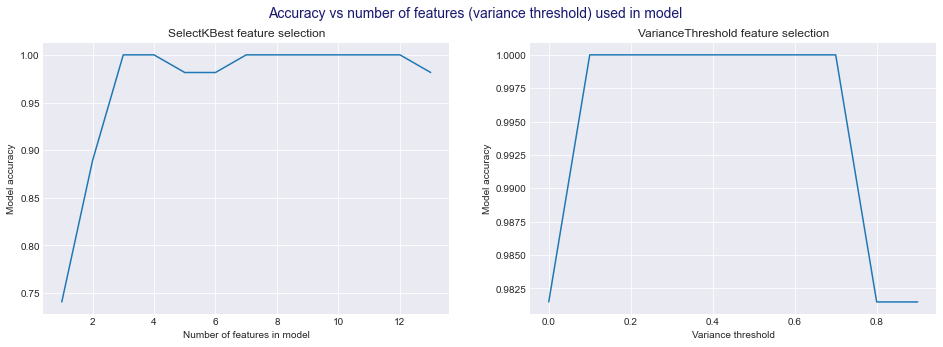

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))
fig.suptitle('Accuracy vs number of features (variance threshold) used in model', c = 'Midnightblue', size = 14)

ax1.plot(ks, kbest_accuracy_list)
ax1.set_title('SelectKBest feature selection')
ax1.set_xlabel('Number of features in model')
ax1.set_ylabel('Model accuracy')

ax2.plot(thresholds, variance_accuracy_list)
ax2.set_title('VarianceThreshold feature selection')
ax2.set_xlabel('Variance threshold')
ax2.set_ylabel('Model accuracy')
plt.show()

According to the left graph, model shows the best accuracy of 1.0 with 3, 4, 7 - 12 features. So, for training speed, only 3 features can be used in the model, and it will show the best score possible. Based on the second graph, model shows the best accuracy of 1.0 with variance threshold between 0.1 - 0.7.

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [31]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [32]:
def covariance(data):
    mean = data.mean()
    std = np.std(data)
    data = np.array((data - mean) / std)
    m = data.shape[0]
    n = data.shape[1]
    covariance = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            covariance[i, j] = np.sum(np.multiply(data[:, i], data[:, j]), axis = 0) / (m - 1)
    return covariance

S = covariance(wine_data)

If your code is correct, the following assert should be Ok.

In [33]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [34]:
from scipy.optimize import minimize

def objective(x):
    # your code: write objective of the problem (don't forget that scipy does min while we need max)
    return -(np.dot(np.dot(x.T, S), x))

def norm_constraint(x):
    # your code: constaraint norm of x to be 1, function should return 0 if constraint holds
    return np.dot(x.T, x) - 1

con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.zeros((S.shape[1]))

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

Hurray! We have first vector! Let's do another one.

In [35]:
def orthogonality_constraint(x):
    # your code: x should be orthogonal to x0, function should return 0 if constraint holds
    return np.dot(x.T, x0)

con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 = np.ones((S.shape[0]))
# your code: initial vector to start optimization


sol = minimize(objective, 
               x1, 
               constraints = [con1, con2] #your code
              )

x1 = sol.x

If your solution is correct, the following asserts should be Ok.

In [36]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

In [37]:
scaled_wine_data = StandardScaler().fit_transform(wine_data)
b = np.hstack((x0.reshape((-1, 1)), x1.reshape(-1, 1)))
two_components_scaled = np.dot(scaled_wine_data, b)

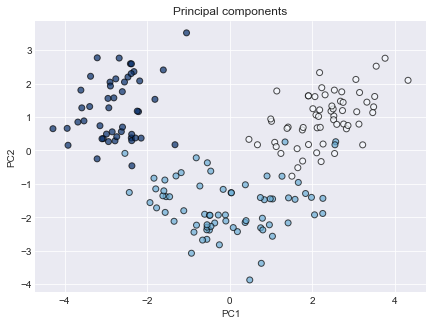

In [38]:
plt.figure(figsize=(7, 5))
plt.scatter(two_components_scaled[:, 0], two_components_scaled[:, 1], alpha = 0.7, c = wine_labels, 
            cmap = 'Blues', edgecolor = 'Black')
plt.title('Principal components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [39]:
from sklearn.decomposition import PCA

pca = PCA()
wine_data_2 = pca.fit_transform(scaled_wine_data)

In [40]:
pca.explained_variance_ratio_

array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294,
       0.04935823, 0.04238679, 0.02680749, 0.02222153, 0.01930019,
       0.01736836, 0.01298233, 0.00795215])

It is determined that 36.2% of dispersion is along the first principal component and 19.2% along the second principal component.

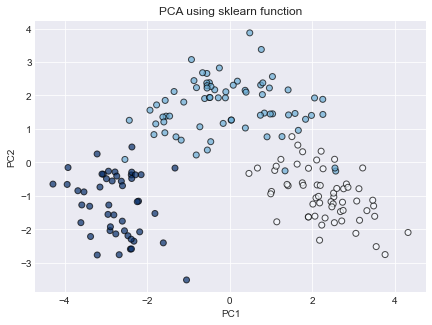

In [41]:
plt.figure(figsize=(7, 5))
plt.scatter(wine_data_2[:, 0], wine_data_2[:, 1], alpha = 0.7, c = wine_labels, cmap = 'Blues', edgecolor = 'Black')
plt.title('PCA using sklearn function')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [42]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

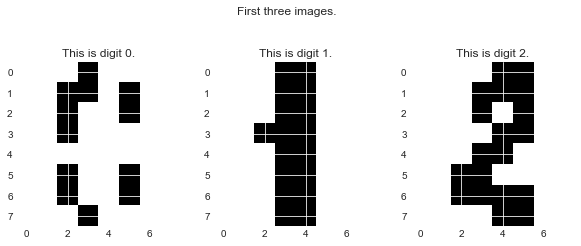

In [43]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [45]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [46]:
clf = RandomForestClassifier(max_depth=13)

clf.fit(X_train, y_train)

acc = clf.score(X_val, y_val)
print(acc)

0.9876543209876543


In [47]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [48]:
! pip install boruta

In [49]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

feat_selector.fit(np.array(X_train), np.array(y_train))
selected_features = X_train.columns[feat_selector.support_].to_list()

In [50]:
print('Total number of features: ', X_train.shape[1])
print('Number of features selected by Boruta: ', X_train[selected_features].shape[1])

Total number of features:  64
Number of features selected by Boruta:  31


Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

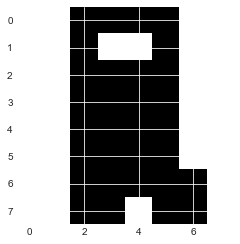

In [51]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

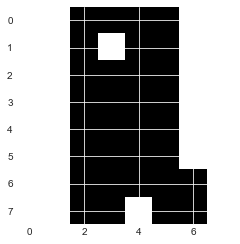

In [52]:
including_weak_support = []
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i] and feat_selector.support_weak_[i]:
        including_weak_support.append(True)
    if feat_selector.support_[i] or feat_selector.support_weak_[i]:
        including_weak_support.append(True)
    else:
        including_weak_support.append(False)
        
mask = np.array(including_weak_support).reshape(8,8)
plt.imshow(mask);

The images show that all valuable pixels, that contain most of information are preserved. 

At the end let us redo  classification but only with selected features

In [53]:
clf = RandomForestClassifier(max_depth=13)

clf.fit(X_train[selected_features], y_train)

acc = clf.score(X_val[selected_features], y_val)
print(acc)

0.9938271604938271


In [54]:
assert acc > 0.99

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market